Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 20, 14, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 20, 14, 10)   1010        input_22[0][0]                   
__________________________________________________________________________________________________
input_21 (InputLayer)           [(None, 20, 14)]     0                                            
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 20, 14, 10)   0           conv2d_6[0][0]                   
___________________________________________________________________________________________

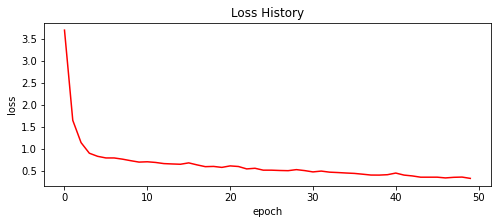

내일은 -0.35% 하락할 것으로 예측됩니다.
예상 주가 = 79723


In [24]:
# LSTM과 CNN을 결합한 모델을 이용해서 주가 수익률을 예측한다.
# 주체별 매매 동향 데이터로 향후 주가 수익률을 추정한다.
from tensorflow.keras.layers import Dense, Input, LSTM, Average
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/순환신경망/삼성전자/삼성전자.csv'
data = pd.read_csv(DATA_PATH , encoding='euc-kr')
last_price = list(data['종가'])[-1]

df = data.dropna()
df = df.drop(['날짜', '종가', '전일비', '개인누적', '기관누적', '외국인누적', '금투누적', '투신누적', '연기금누적', '국가지자체'], axis=1)

# feature 표준화
rtn_mean = df['등락율'].mean()   # 복원을 위해 저장해 둔다.
rtn_std = df['등락율'].std()
df = (df - df.mean()) / df.std()

# 2차원 배열의 feature 데이터로 LSTM 학습 데이터를 만든다.
def build_train_data(data, t_step, n_jump = 1):
    n_data = data.shape[0]   # number of data
    n_feat = data.shape[1]   # number of features

    m = np.arange(0, n_data - t_step, n_jump)   # m =  [0, 1, 2, 3, 4, 5]
    x = [data[i:(i+t_step), :] for i in m]      # feature data
    y = [data[i, :] for i in (m + t_step)]      # target data

    # shape을 조정한다. feature = 3D, target = 2D
    x_data = np.reshape(np.array(x), (len(m), t_step, n_feat))
    y_target = np.reshape(np.array(y), (len(m), n_feat))
    
    return x_data, y_target

t_step = 20

# 학습 데이터를 생성한다.
x_train, y_train = build_train_data(np.array(df), t_step, n_jump=1)
x_train.shape, y_train.shape

n_feat = x_train.shape[2]
n_output = y_train.shape[1]
n_hidden = 128

# LSTM 모델을 생성한다.
x_lstm_input = Input(batch_shape=(None, t_step, n_feat))
x_lstm = LSTM(n_hidden, return_sequences=True)(x_lstm_input)
x_lstm = LSTM(n_hidden, dropout=0.2)(x_lstm)

# CNN 모델을 생성한다.
x_cnn_input = Input(batch_shape = (None, t_step, n_feat, 1))
x_conv = Conv2D(filters=10, kernel_size=(20,5), strides=1, padding = 'same', activation='relu')(x_cnn_input)
x_pool = MaxPooling2D(pool_size=(10,5), strides=1, padding='same')(x_conv)
x_flat = Flatten()(x_pool)
x_cnn = Dense(n_hidden)(x_flat)

# 두 네트워크를 합친다.
x_avg = Average()([x_lstm, x_cnn])
y_output = Dense(n_feat)(x_avg)

model = Model([x_lstm_input, x_cnn_input], y_output)
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
model.summary()

# 학습한다
h = model.fit([x_train, x_train.reshape(-1, t_step, n_feat, 1)], y_train, epochs=50, batch_size=32, shuffle=True)

# Loss history를 그린다
plt.figure(figsize=(8, 3))
plt.plot(h.history['loss'], color='red')
plt.title("Loss History")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# 내일의 수익률과 주가를 예측한다.
px_lstm = np.array(df.tail(20)).reshape(1, t_step, n_feat)
px_cnn = px_lstm.reshape(1, t_step, n_feat, 1)
y_pred = model.predict([px_lstm, px_cnn])[0][0]
y_rtn = y_pred * rtn_std + rtn_mean

if y_rtn > 0:
    print("내일은 {:.2f}% 상승할 것으로 예측됩니다.".format(y_rtn * 100))
else:
    print("내일은 {:.2f}% 하락할 것으로 예측됩니다.".format(y_rtn * 100))
print("예상 주가 = {:.0f}".format(last_price * (1 + y_rtn)))
